# Forrestania: Gravity & Magnetics (Pure Python)

```{figure} ./images/landing.png
---
scale: 30%
align: right
---
```

This case study focuses on the standalone and joint inversion of ground gravity and airborne magnetic data, all using open-source libraries. It uses public data downloaded from the [Geological Survey of Western Australia](https://portal.ga.gov.au/persona/gadds) over the Forrestania geological province. We cover the following steps

- [Data imports and pre-processing](forrestania-data-os)
- [Standalone inversion of gravity data](forrestania-gravity-os)
- [Standalone inversion of magnetic data](forrestania-magnetics-os)
- [Joint cross-gradient inversion](forrestania-joint-os)
- [K-means clustering analysis](forrestania-kmeans-os)

In [140]:
# Import the core libraries that we will need
import zipfile
from pathlib import Path
from tempfile import mkdtemp

import discretize
import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy as sp
import simpeg
from geoh5py import Workspace, objects
from PIL import Image

from simpeg_drivers import assets_path

## Geological setting

To be completed...

(forrestania-data-os)=
## Data

We first need to unzip the package and import the data into a usable format.

In [142]:
temp_dir = Path(mkdtemp())
file = assets_path() / r"Case studies/Forrestania_SRTM1 Australia_MGA50_CSV.zip"
with zipfile.ZipFile(file, "r") as zf:
    zf.extractall(temp_dir)

files = list(temp_dir.iterdir())

The package containes the following three files:
 - Airborne magnetic survey: `60472_AOI4.csv`
 - Ground gravity survey: `Forrestania_Gravity_Station_trim_.csv`
 - Digital Elevation Model (DEM): `Forrestania_SRTM1 Australia_MGA50.tiff`

In [141]:
# Read the two CSVs with pandas
mag_survey = pandas.read_csv(files[0])
grav_survey = pandas.read_csv(files[1])

# Read the geotiff with geoh5py
ws = Workspace()
geotiff = objects.GeoImage.create(ws, image=str(files[2]))
geotiff.georeferencing_from_tiff()

### Processing

We will convert each element to a numpy array.

#### Step 1: Convert the geoImage in a 2D Grid with values

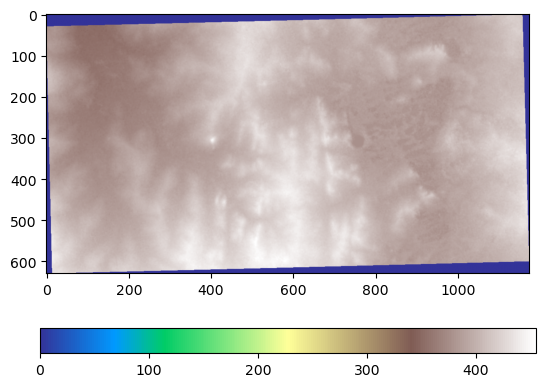

In [123]:
grid = geotiff.to_grid2d()
elevations = grid.children[0].values

fig, ax = plt.subplots()
im = plt.imshow(elevations.reshape(grid.shape, order="F").T, cmap="terrain")
plt.colorbar(im, orientation="horizontal")

We also need to remove the zeros from the rotated DEM.

In [124]:
elevations.min()

np.float64(1.1754943508222875e-38)

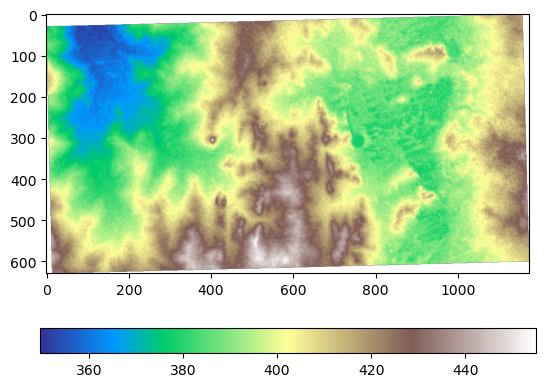

In [125]:
logic = np.abs(elevations) < 2e-38
elevations = np.where(logic, np.nan, elevations)
fig, ax = plt.subplots()
im = plt.imshow(elevations.reshape(grid.shape, order="F").T, cmap="terrain")
plt.colorbar(im, orientation="horizontal")

In [126]:
# Our final DEM grid
dem = np.c_[grid.centroids[:, :2], elevations]

#### Step 2: Extract the magnetic data and format

There are a lot more information that we need from the original CSV, but also some that are missing.

In [127]:
mag_survey

,X,Y,Z,Band 1,CHORDLEN,COSMIC,DATE,DIURNAL,FIDUCIAL,FLIGHT,...,THORAW,TIME,TOTRAW,URARAW,X_MGA50,X_MGA51,xEAST1,Y_MGA50,Y_MGA51,yNORTH1
0,749098.69,6419105.5,447.29,385.29,5752.7,28.0,19880216.0,58877.6,353.0,8.0,...,146.0,12272.8,2213.0,81.0,749098.7,184334.8,748955.9,6419105.5,6417239.5,6418957.0
1,749081.69,6419105.5,448.28,386.28,5735.7,24.7,19880216.0,58877.6,352.0,8.0,...,142.3,12272.4,2128.3,77.2,749081.7,184317.9,748938.9,6419105.5,6417238.5,6418957.0
2,749064.56,6419105.5,449.19,387.19,5718.6,21.5,19880216.0,58877.6,351.0,8.0,...,138.5,12272.0,2043.5,73.5,749064.6,184300.8,748921.8,6419105.5,6417237.5,6418957.0
3,749047.44,6419105.5,449.19,387.19,5701.5,18.3,19880216.0,58877.6,350.0,8.0,...,134.8,12271.6,1958.8,69.7,749047.4,184283.7,748904.7,6419105.5,6417236.5,6418957.0
4,749030.38,6419105.5,449.15,387.15,5684.4,15.0,19880216.0,58877.6,349.0,8.0,...,131.0,12271.2,1874.0,66.0,749030.4,184266.6,748887.6,6419105.5,6417235.5,6418957.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,744737.44,6416867.0,432.49,377.69,23716.5,22.8,19880216.0,58896.1,2806.0,8.0,...,113.5,5250.2,1896.0,74.5,744737.4,180103.8,744594.7,6416867.0,6414759.0,6416718.5
4038,744719.31,6416867.0,432.17,377.67,23734.6,24.5,19880216.0,58896.1,2807.0,8.0,...,119.0,5250.6,1976.0,76.0,744719.3,180085.8,744576.6,6416867.0,6414758.0,6416718.5
4039,744701.13,6416867.0,431.87,377.67,23752.8,26.2,19880216.0,58896.1,2808.0,8.0,...,124.5,5251.0,2056.0,77.5,744701.1,180067.6,744558.4,6416867.0,6414757.0,6416718.5
4040,744683.00,6416866.5,431.69,377.69,23770.9,28.0,19880216.0,58896.1,2809.0,8.0,...,130.0,5251.4,2136.0,79.0,744683.0,180049.5,744540.3,6416866.5,6414755.0,6416718.0


#### Step 2a: Transfer the DEM data onto the airborne survey (curve). 

There are currently no absolute elevations for this survey, only the height above the DEM. So we will need to extract it from the grid.
The fastest interpolation is a nearest neighbour.

In [130]:
# Make a temporary locations
mag_locs = mag_survey[["X_MGA50", "Y_MGA50", "RADALT"]].to_numpy()

# Only use the 2D location for the nearest position
tree = sp.spatial.cKDTree(dem[:, :2])
_, ind = tree.query(mag_locs[:, :2])

# Re-assign elevation from DEM
mag_locs[:, 2] += dem[ind, 2]

In [131]:
np.nanmax(dem[:, 2])

np.float64(455.0)

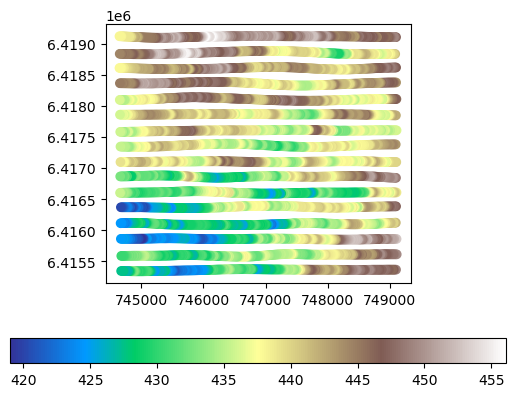

In [139]:
fig, ax = plt.subplots()
im = plt.scatter(mag_locs[:, 0], mag_locs[:, 1], c=mag_locs[:, 2], cmap="terrain")
plt.colorbar(im, orientation="horizontal")
ax.set_aspect(1)

(forrestania-gravity-os)=
## Gravity

We begin our analysis with the ground gravity survey. We will attempt to estimate the shape and depth of the causative body at depth.

### Inputs

Gravity data are sensitive to variations in the density of rocks. The data were already processed and provided as terrain-corrected (2.67 g/cc) residual data. We can therefore go directly to the inversion phase. 

```{figure} ./images/gravity_data.png
```

### Inversion options

The following options are set for the inversion.

```{figure} ./images/gravity_setup.png
---
scale: 10%
---
[Click to enlarge]
```
- Assign the data uncertainty to a quarter of the standard deviation (0.05 mGal). This is a somewhat conservative estimate that takes into account both the instrumental and numerical noise.
- Use a `0 g/cc` reference value for the model. This assumes that the signal from the background density was accurately subtracted from the data.
- Leave the `Mesh` option unchecked. We will let the code create an octree mesh based on the average data separation and extent.

### Results

After completion of the inversion, we load the results and assess convergence and data fit.

```{figure} ./images/grav_predicted.png
```

We note the following:

 - It took 13 iterations to converge to the target misfit.
 - The following 12 iterations have increased the model complexity ($phi_m$) but preserved the data fit ($phi_d$).
 - Most of the important gravity anomalies appear to be reproduced by the final model.

#### Smooth solution (L2-norm)

```{figure} ./images/grav_l2_model.png
```

The smooth solution (iteration 13) indicates the presence of a dense anomaly extending at depth with density contrasts ranging from [-0.02, 0.05] g/cc. The negative density contrasts appear to be localized around the main positive anomaly, likely due to the smoothness constraint and the lack of `bound` constraints. Some smaller "fuzzy" anomalies are visible at the margins.  

#### Compact solution (L0-norm)

```{figure} ./images/grav_lp_model.png
```

As an alternative solution, the compact model (iteration 25) recovers a well-defined dense body within a mostly uniform background. Density contrasts have substantially increased in the range of [0.0, 0.56] g/cc.

<p style="page-break-after:always;"></p>

(forrestania-magnetics-os)=
## Magnetics

We follow up with the processing of the airborne magnetic data.

### Inputs

The source of the magnetic signal can generally be attributed to the presence or destruction of magnetic minerals in rocks (mainly magnetite). Magnetometers measure the Total Magnetic Intensity (TMI), which includes both the primary (source) field and secondary fields (signal) from the local geology. 

#### Step 1: Residual data

The inversion routine requires Residual Magnetic Intensity (RMI). The first step is to compute and remove the primary field (IGRF) at the time and location of acquisition.  The survey was conducted between February and March 1988.

##### Step 1a: Set the coordinate system of the survey

Before computing the IGRF, we need to locate the survey in world coordinates. This specific project is referenced to the `MGA zone 50` coordinate system.

```{figure} ./images/mag_coordinates.png
---
scale: 10%
---
[Click to enlarge]
```

##### Step 1b: Lookup/remove IGRF 

```{figure} ./images/mag_igrf.png
---
scale: 10%
---
[Click to enlarge]
```

The **inducing field parameters** at the time and location of the survey are

- Magnitude: 59127 nT
- Inclination: -66.9$\degree$
- Declination: -1.05$\degree$  

#### Step 2: Detrend
The local background field appears to be slightly lower (~112 nT) than the computed IGRF model, as most of the data away from the main anomaly are below 0. To avoid modelling this background trend, we can remove the median value. 

```{figure} ./images/mag_detrend.png
---
scale: 10%
---
[Click to enlarge]
```

#### Step 3: Downsampling

We can downsample the data along lines to reduce the computation cost of the inversion. Since the average flight height of this survey was 60 m, we can confidently downsample the lines by the same amount without affecting the wavelengths contained in the data.

```{figure} ./images/mag_downsample.png
---
scale: 10%
---
[Click to enlarge]
```

### Create a mesh

This time, we will create a mesh using the [Octree Mesh Creation](mesh-design) application. In preparation for the joint inversion, we will simply modify the gravity mesh parameters. By doing so, we guarantee that the extent and base cell size remain the same, only the refinements will be optimized to the magnetic survey.

```{figure} ./images/mag_mesh.png
```

#### Step 1: Load the octree parameters
Inspect the files attached to the gravity mesh object and load the `ui.json`.

#### Step 2: Modify the refinements
Change the input object for `Refinement A` for the curve object of the magnetic survey.

#### Step 3: Run and load the results

 
### Inversion options

The following options are set for the inversion.

```{figure} ./images/mag_setup.png
---
scale: 10%
---
[Click to enlarge]
```

- Set the inducing field parameters as described above.
- Assign the data uncertainty to a quarter of the standard deviation (125 nT).
- Use a `0 SI` reference value for the model. This assumes that we removed all background signal from the data.
- Assign the newly created octree mesh object.
- Leave the default lower bound value to 0 SI (non-negative). 

### Results

After completion of the inversion, we load the results and assess convergence and data fit.

```{figure} ./images/mag_predicted.png
```

We note the following:

 - It took 5 iterations to converge to the target misfit.
 - The following 21 iterations have increased the model complexity ($phi_m$) while preserving the data fit ($phi_d$).
 - Small anomalies are under-fitted, which could warrant a second inversion with lower uncertainties.

#### Smooth solution (L2-norm)

```{figure} ./images/mag_l2_model.png
```

The smooth solution (iteration 5) indicates the presence of a susceptible body at depth. The shape and location of the anomaly resemble the solution obtained with the gravity modelling, including the presence of smaller "fuzzy" anomalies at the margins.  

#### Compact solution (L0-norm)

```{figure} ./images/mag_lp_model.png
```

As an alternative solution, the compact model (iteration 21) recovers a well-defined dense body within a mostly uniform background. Susceptibility contrasts have substantially increased in the range of [0.0, 2.0] SI.


(forrestania-joint-os)=
## Joint cross-gradient

After inverting the gravity and magnetic data independently, and recovering anomalies with similar shapes and positions in both, the next step is to invert both datasets jointly. We are going to employ the cross-gradient constraint to promote alignment of edges in the density and susceptibility models. 

### Inversion options

The following options are set for the inversion.

```{figure} ./images/joint_setup.png
---
scale: 10%
---
[Click to enlarge]
```

- Select the two existing inversion groups (magnetic and gravity) to Group A and B.
- Leave the mesh option empty. The routine will generate *an inversion mesh* based on the best resolution from both the gravity and magnetic problems.
- Set the topography

### Results

After completion of the inversion, we load the results

```{figure} ./images/joint_lp_model.png
```

We note the following:

- The shape of the density and magnetic susceptibility models match closely near the main anomaly.
- Some of the smaller anomalies, as well as an extension to the north-east, are only seen in the density model.

(forrestania-kmeans)=
## Analysis

The joint inversion results highlight a few features that could be distinguished by their physical property contrasts.
After running a K-means clustering on the final models, we recover the following simplified petrophysical model with 4 units.

```{figure} ./images/joint_kmeans.png
```

This table summarizes the different units based on their mean density and susceptibility values. 

```{table} Summary of expected physical properties
| Unit | Susceptibility | Density |
| :--- | :--- | :---- |
| background |  low    | low      |
| A |  high    | high      |
| B |  low    | high      |
| C |  high | low |
```

## Summary

- We have inverted publicly available data over the Forrestania geological province.

- The joint cross-gradient method was successfull in promoting similarities between the different physical properties wherever possible.

- Our results suggest the presence of different geological units with distinct density and magnetic susceptibility signatures.
